### Data description

- cmplnt_num -> unique number of every reported crime 
- police_precincts -> 77 police precincts, podzielone na dzielnice (https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page)
- district -> name of a discrict where crime was commited
- crime_date -> date of the crime
- crime_time -> time of the crime
- case_solved -> tag whether a given case was solved 
- housing_dev_name -> column shows whether particular crime is connected with a person living in a housing development 
- id_housing_dev -> id housing development
- ofns_level -> Level of offense: felony (hard), misdemeanor (middle), violation (easy)
- loc_of_occur_desc -> specific location of occurrence in or around the premises; inside, opposite of, front of, rear of (connected with prem_typ_desc)
- ofns_desc -> type of a crime 
- parks_nm -> accurate name of a place where a crime was commited
- detail_ofns_desc -> detailed type of a crime 
- prem_typ_desc -> detailed description of a place where crime was commited (connected with loc_of_occur_desc)
- notification_date -> date when the crime was reported 
- notification_station_name -> police station where the crime was reported
- susp_age_group -> suspect age group 
- susp_race -> suspect race 
- susp_sex -> suspect sex 
- vic_age_group -> victim age group 
- vic_race -> victim race 
- vic_sex -> victim sex, Victim’s Sex Description (D=Business/Organization, E=PSNY/People of the State of New York, F=Female, M=Male)
- latitude 
- longitude
- lat_lon
- district population

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import geopandas
import contextily as ctx
from itertools import cycle
pd.set_option('display.max_columns',30)

# Loading and cleaning data

In [6]:
df = pd.read_excel("data.xlsx", index_col='CMPLNT_NUM')

In [7]:
pd.set_option('display.max_rows',85)

In [8]:
#cleaning data and preparing it for analysis
columns=['JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'PATROL_BORO', 'PD_CD', 'TRANSIT_DISTRICT', 
         'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'X_COORD_CD', 'Y_COORD_CD']

to_del_susp_age_group = [-965,-966, -964, -973, -968, -64, 930, -1, -80, 947, 929, 1019, 940, 2019, 924]
to_del_vic_age_group = [-961, -952, 936, -71, -943, 956, -50, 941, -942, -39, 1013, -69, -67, 937, -946, -974, 951, 960, 
                        927, -2,938, -934, -978, -970, -56, -954, 943, 929, -967, 1018, -948]
#deleting columns
df.drop(columns=columns, inplace=True)

#changing values for boolean
df['CRM_ATPT_CPTD_CD'].replace({'COMPLETED':1, 'ATTEMPTED':0}, inplace=True)

#deleting wrong values from susp_age_group and vic_age_group columns
for x in to_del_susp_age_group:
    filt = df['SUSP_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)
    
for x in to_del_vic_age_group:
    filt = df['VIC_AGE_GROUP'] == x
    df.drop(index = df[filt].index, inplace=True)

#usunięcie wartości Nan z boro_nm i ofns_desc
df = df[~df['BORO_NM'].isnull()]
df = df[~df['VIC_AGE_GROUP'].isnull()]
df.dropna(how='any', subset=['OFNS_DESC', 'PREM_TYP_DESC'], inplace=True)

#changin and unifying values
df["SUSP_AGE_GROUP"].replace( np.nan, 'UNKNOWN', inplace=True)
df['SUSP_RACE'].replace(np.nan, 'UNKNOWN', inplace=True)
df['SUSP_SEX'].replace('U', 'UNKNOWN', inplace=True)

#changing type of data of columns with dates
date_columns = ['CMPLNT_FR_DT', 'RPT_DT']

for x in date_columns:
    df[x] = df[x].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
    df[x] = df[x].map(lambda x: x.date())

df['crime_day'] = df['CMPLNT_FR_DT'].map(lambda x: x.isoweekday())
df['crime_month'] = df['CMPLNT_FR_DT'].map(lambda x: x.month)
    
df.columns = [x.lower() for x in df.columns]

In [9]:
#changing columns names for simpler and more unambiguous and reordering them
df.rename(columns={"cmplnt_num":'case_id', 'addr_pct_cd':'police_precincts', 'boro_nm':'district', 
                   'cmplnt_fr_dt':'crime_date', 'cmplnt_fr_tm':'crime_time','cmplnt_to_dt':'end_crime_date', 
                   'cmplnt_to_tm':'end_crime_time', 'crm_atpt_cptd_cd':'case_solved', 'hadevelopt': 'housing_dev_name',
                   'housing_psa':'id_housing_dev','law_cat_cd': 'ofns_level',
                   'pd_desc': 'detail_ofns_desc', 'rpt_dt': 'notification_date', 
                   'station_name':'notification_station_name'}, inplace=True)

In [10]:
#deleting rows with strange values in crime_year column (extremely low year values)
years = [1018, 1019, 1029]

#creatig temporary column "years"
df['years'] = df['crime_date']
df['years'] = df['years'].map(lambda x: x.year)

filt = df['years'].isin(years)
df = df[~filt]

#deleting temporary column "years"
df.drop(columns='years', inplace=True)

In [11]:
#NY population by Borough
ny_population = {
    'district': ['Total', 'BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'],
    'population': [8550971, 1446788, 2648452, 1638281, 2330295, 487155]
}
ny_population = pd.DataFrame(ny_population)

In [12]:
#adding new column with population depending on distric
df = df.merge(ny_population, on='district', how='left')

In [13]:
df.rename(columns={'population':'disctrict_population'}, inplace=True)

In [14]:
#adding new column -> time span between crime commitment
df['time_crime_report'] = '' 
df['notification_date'] = pd.to_datetime(df['notification_date'])
df['crime_date'] = pd.to_datetime(df['crime_date'])
df['time_crime_report'] = (df['crime_date'] - df['notification_date']).abs().dt.days

In [15]:
#reordering columns
df = df[['crime_date', 'crime_time', 'crime_day', 'crime_month', 'time_crime_report', 'district',
         'disctrict_population', 'case_solved', 'ofns_desc', 'detail_ofns_desc', 'ofns_level', 
         'loc_of_occur_desc', 'prem_typ_desc', 'parks_nm', 'susp_age_group', 'susp_race', 
         'susp_sex', 'vic_age_group', 'vic_race', 'vic_sex', 'notification_date', 'notification_station_name',
         'latitude', 'longitude', 'lat_lon', 'police_precincts','housing_dev_name', 'id_housing_dev']]

In [16]:
#transforming crime_time column
df["crime_time"] = df["crime_time"].map(lambda x: x.hour)

# Data exploration and visualisation

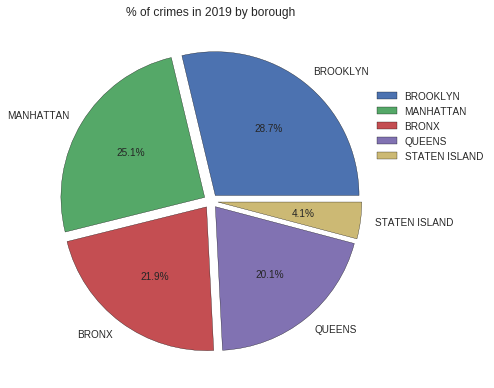

In [17]:
# %crimes by districts 
plt.style.use('seaborn')

pie_data = df['district'].value_counts(normalize=True)
explode = [0.05, 0.05, 0.05, 0.05, 0.05]
labels = df['district'].value_counts(normalize=True).index

plt.pie(pie_data, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'})

plt.title('% of crimes in 2019 by borough')
plt.legend(loc=(.95, .6))

plt.tight_layout()

We can see in above pie chart that in 2019 the highest number of crimes were commited in Brooklyn (28.7%) and the lowest in Staten Island (4.1%)

        district  police_precincts  population  crimes/population
2      MANHATTAN            115596     1638281          70.559324
0          BRONX            100760     1446788          69.643928
1       BROOKLYN            132095     2648452          49.876305
3         QUEENS             92325     2330295          39.619447
4  STATEN ISLAND             18956      487155          38.911640


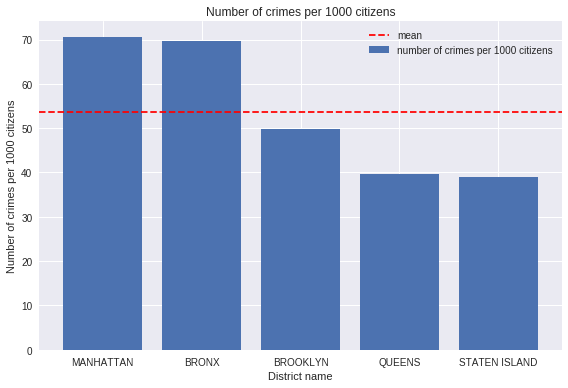

In [18]:
#nb of crimes by district/district population 

nb_crim_dist_pop = df.groupby(['district']).count().merge(ny_population, on='district', how='left')
nb_crim_dist_pop = nb_crim_dist_pop[['district', 'police_precincts', 'population']]
nb_crim_dist_pop['crimes/population'] = (nb_crim_dist_pop.police_precincts/nb_crim_dist_pop.population)*1000
nb_crim_dist_pop.sort_values(by='crimes/population', inplace=True, ascending=False)
mean = nb_crim_dist_pop['crimes/population'].mean()
print(nb_crim_dist_pop)

plt.bar(nb_crim_dist_pop.district, nb_crim_dist_pop['crimes/population'], 
        label='number of crimes per 1000 citizens')

plt.axhline(mean, color='red', linestyle='--', label='mean')

plt.title('Number of crimes per 1000 citizens')
plt.ylabel('Number of crimes per 1000 citizens')
plt.xlabel("District name")
plt.legend()
plt.tight_layout() 

The above graph illustrates which boroughs have the highest number of crimes per 1000 citizens. It is easy to spot that the most serious issue with crime rate above the mean value have two districts: Manhattan and Bronx. 
Probably those issues in the first of mentioned districts are caused by the fact that it is widely popular among turists. However the second one is commonly known from poverty and crimes. 

district       ofns_level 
BRONX          FELONY         0.28
               MISDEMEANOR    0.55
               VIOLATION      0.17
BROOKLYN       FELONY         0.33
               MISDEMEANOR    0.51
               VIOLATION      0.16
MANHATTAN      FELONY         0.31
               MISDEMEANOR    0.56
               VIOLATION      0.13
QUEENS         FELONY         0.32
               MISDEMEANOR    0.52
               VIOLATION      0.17
STATEN ISLAND  FELONY         0.25
               MISDEMEANOR    0.54
               VIOLATION      0.22
Name: crime_date, dtype: float64


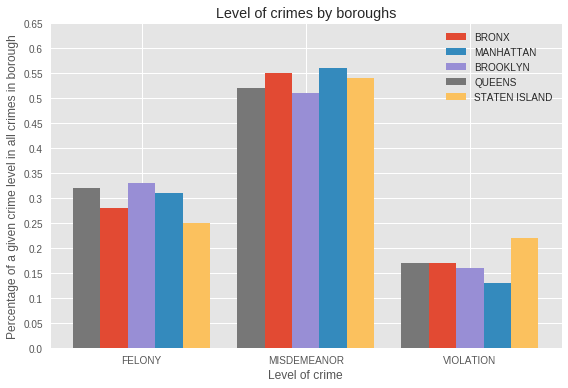

In [19]:
# %poważnych przestępstw ze względu na dzielnice 
plt.style.use('ggplot')

ofns_level_dist = df.groupby(['district', 'ofns_level']).count()['crime_date']
ofns_level_dist = ofns_level_dist.transform(lambda x: (x/x.sum(level=0)).round(2))

idx = list(set(ofns_level_dist.index.get_level_values(1)))
x_indexes = np.arange(len(idx))
width = 0.167

data_bronx = ofns_level_dist.loc["BRONX"]
data_manhattan = ofns_level_dist.loc['MANHATTAN']
data_brooklyn = ofns_level_dist.loc['BROOKLYN']
data_queens = ofns_level_dist.loc['QUEENS']
data_staten = ofns_level_dist.loc['STATEN ISLAND']

plt.bar(x_indexes-width, data_bronx, width=width, label="BRONX")
plt.bar(x_indexes+width, data_manhattan, width=width, label='MANHATTAN')
plt.bar(x_indexes, data_brooklyn, width=width, label='BROOKLYN')
plt.bar(x_indexes-2*width, data_queens, width=width, label='QUEENS')
plt.bar(x_indexes+2*width, data_staten, width=width, label='STATEN ISLAND')

plt.title("Level of crimes by boroughs")
plt.xlabel("Level of crime")
plt.ylabel("Percentage of a given crime level in all crimes in borough")
plt.xticks(ticks=x_indexes, labels=ofns_level_dist.index.get_level_values(1))
plt.yticks(ticks=np.linspace(0, .65, 14), labels=np.linspace(0, .65, 14).round(2))

plt.legend()

plt.tight_layout()
print(ofns_level_dist)

The graph confirms that Staten Island is the most safe borough, this district has the highest percentage of soft  crimes - 22%. On the other side there are Brooklyn and Manhattan. When considering only felonies, we can see that Brooklyn and Queens should be percived as dangerous parts of NY city. When comparing two above plots, it could be stated certainly that Staten Iland is the most secure borough in New York. 

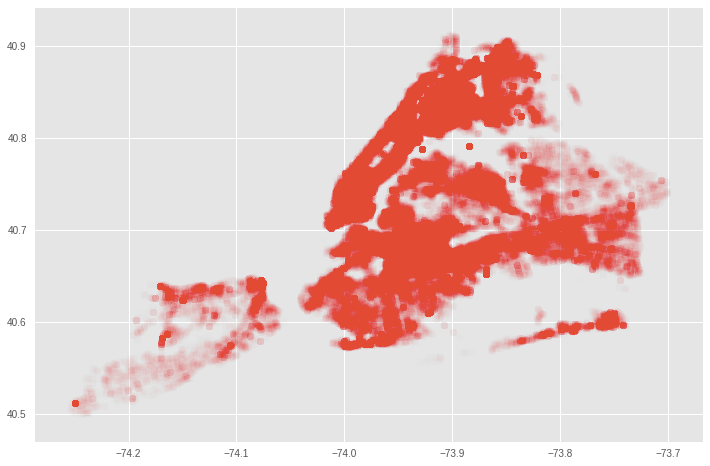

In [20]:
df_map = geopandas.read_file(geopandas.datasets.get_path('nybb'))
df_map = df_map.to_crs(epsg=3857)

plt.figure(figsize=(12, 8))
lon = df['latitude']
lat = df['longitude']

plt.scatter(lat, lon, alpha=0.005)

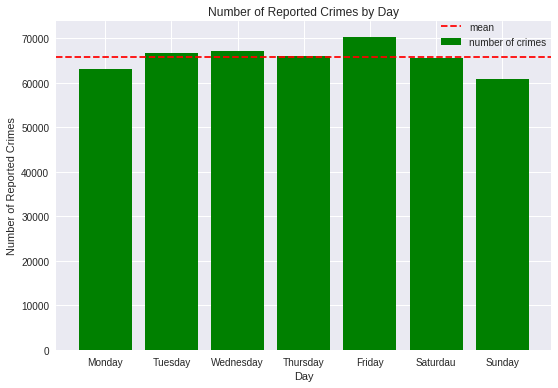

In [21]:
#number of crimes by day bar plot
plt.style.use('seaborn')

bar_days = df['crime_day'].value_counts().sort_index()
ticks = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturdau', 'Sunday']
num = list(range(1,8))
mean = bar_days.mean()

plt.bar(bar_days.index, bar_days,color='green', label='number of crimes')
plt.axhline(mean, color='red', linestyle='--', label='mean')

plt.xticks(num, ticks)

plt.title('Number of Reported Crimes by Day')
plt.xlabel('Day')
plt.ylabel("Number of Reported Crimes")
plt.legend(loc=(.77,.91))

plt.tight_layout() 
#


On a graph named "Number of Reported Crimes by Day" we could see that during friday nights police observed a increase in criminal activities. It could be caused by the fact that huge amount of people attend parties and go out to the city centers especially on fridays. 

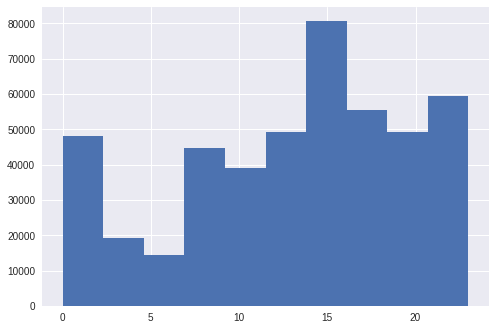

In [22]:
df["crime_time"].hist()
#możę o 15 napad na starszych ludzi? -> sprawdzić 
#najwięcej przestępstw o 15 co może być związane ze szczytem komunikacyjnym, najspokojniej w godzinach nocnych 
#co jest oczywsite

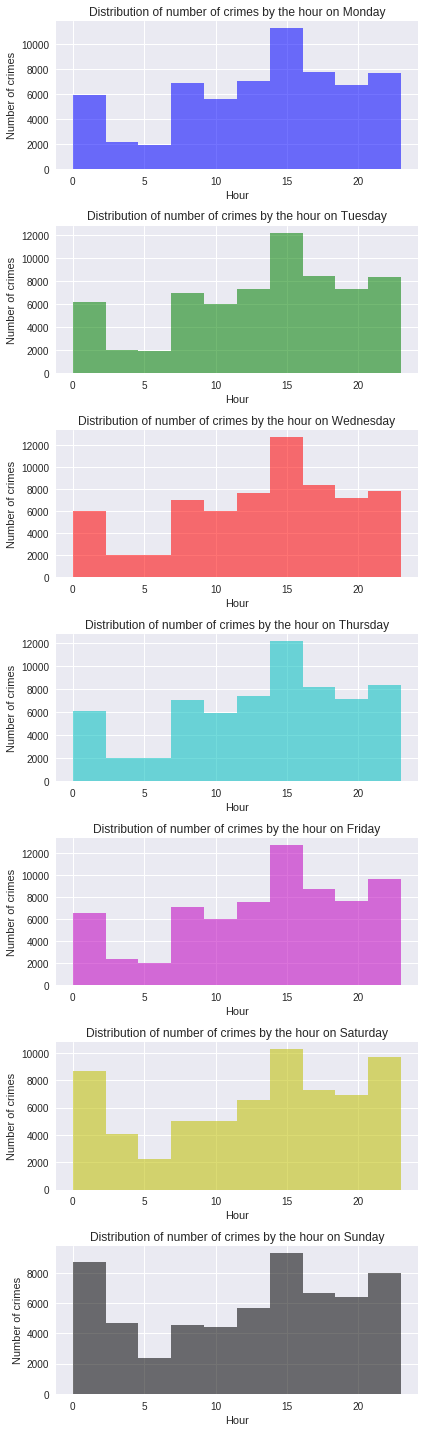

In [23]:
crime_days = pd.DataFrame()
days = []
dfs = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
cycol = cycle('bgrcmyk')

for x in range(1,8):
    filt = df["crime_day"] == x
    df_day = df[filt][["crime_day", 'crime_time']]
    days.append(df_day)

fig, axis = plt.subplots(7, 1, figsize=(6,20))
    
for x,y in zip(days, range(0,8)):
    axis[y].hist(x["crime_time"], color=next(cycol), alpha=0.55)
    #axis[y].set_yticklabels(labels=np.linspace())
    axis[y].set_title("Distribution of number of crimes by the hour on " + dfs[y])
    axis[y].set_ylabel("Number of crimes")               
    axis[y].set_xlabel("Hour")   
                   
plt.tight_layout()

In [24]:
#sprawdzic jak z tymi kradziezami, czy w pt wieczory serio jest więcej kradziży 
#czy poważniejsze typy przestępstw są wieczorami ?

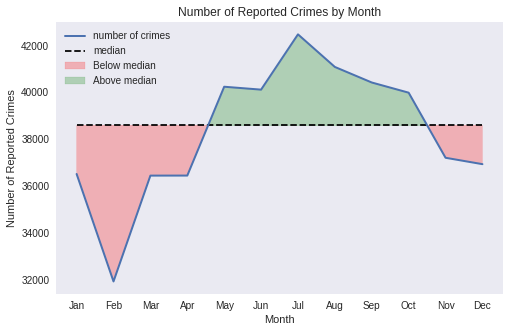

In [26]:
#number of crimes by month - line plot
ticks=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
num = list(range(1,13))
plt.figure(figsize=(8, 5))

crimes_month = df['crime_month'].value_counts().sort_index()
median = crimes_month.median()

plt.plot(crimes_month.index, crimes_month, label='number of crimes', linewidth=2)
plt.hlines(median, 1, 12, linestyle='--', label='median')

plt.title('Number of Reported Crimes by Month')
plt.xlabel('Month')
plt.ylabel("Number of Reported Crimes")
plt.xticks(num, ticks)

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median>crimes_month),
                interpolate=True,
                alpha=0.25,
                color='red',
                label='Below median'
                )

plt.fill_between(crimes_month.index, crimes_month,
                median, where=(median<=crimes_month),
                interpolate=True,
                alpha=0.25,
                color='green',
                label='Above median'
                )

plt.legend()
plt.grid(0)
#plt.plot(crimes_month.index, crimes_month)

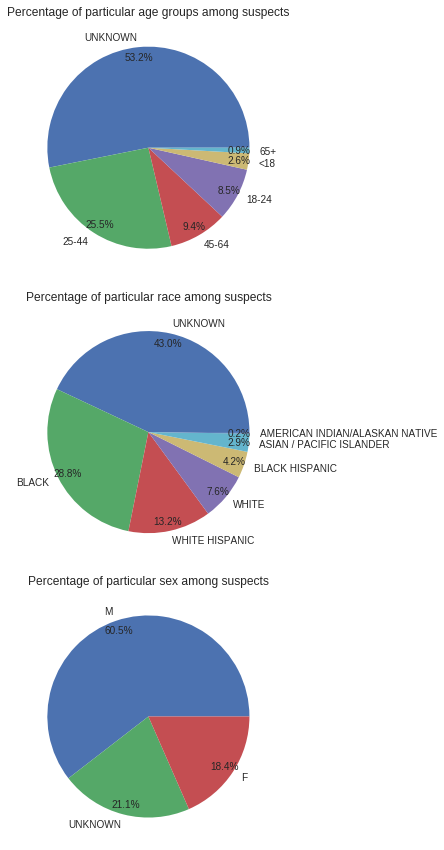

In [27]:
#susp pie plots

data_susp_1 = df['susp_age_group'].value_counts(normalize=True)
data_susp_2 = df['susp_race'].value_counts(normalize=True)
data_susp_3 = df['susp_sex'].value_counts(normalize=True)

plt.style.use("fast")
fig, axis = plt.subplots(3, 1, figsize=(6,12))
plt.tight_layout()

axis[0].pie(data_susp_1, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_1.index)
axis[0].set_title('Percentage of particular age groups among suspects')

axis[1].pie(data_susp_2, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_2.index)
axis[1].set_title('Percentage of particular race among suspects')
#axis[1].legend(labels=data_susp_2.index, loc=(0.85,.6))

axis[2].pie(data_susp_3, autopct='%1.1f%%', pctdistance=0.9, labels=data_susp_3.index)
axis[2].set_title('Percentage of particular sex among suspects')
#axis[2].legend(labels=data_susp_2.index, loc=(0,.82))

plt.show()

In [28]:
#'vic_age_group', 'vic_race', 'vic_sex'

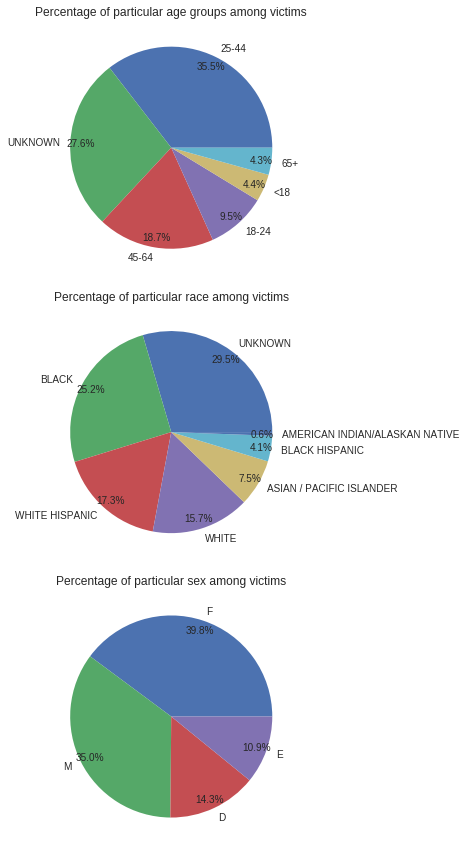

In [29]:
#victims pie plots

data_vic_1 = df['vic_age_group'].value_counts(normalize=True)
data_vic_2 = df['vic_race'].value_counts(normalize=True)
data_vic_3 = df['vic_sex'].value_counts(normalize=True)

plt.style.use("fast")
fig, axis = plt.subplots(3, 1, figsize=(6,12))
plt.tight_layout()

axis[0].pie(data_vic_1, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_1.index)
axis[0].set_title('Percentage of particular age groups among victims')

axis[1].pie(data_vic_2, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_2.index)
axis[1].set_title('Percentage of particular race among victims')


axis[2].pie(data_vic_3, autopct='%1.1f%%', pctdistance=0.9, labels=data_vic_3.index)
axis[2].set_title('Percentage of particular sex among victims')


plt.show()

In [30]:
df['ofns_level'].value_counts()

MISDEMEANOR    245453
FELONY         141877
VIOLATION       72402
Name: ofns_level, dtype: int64

In [31]:
group_district_ofns_desc = df.groupby(['district', 'ofns_level'])['police_precincts'].count()

In [32]:
df['parks_nm'].value_counts()

WASHINGTON SQUARE PARK            211
CENTRAL PARK                      205
FLUSHING MEADOWS CORONA PARK      199
CONEY ISLAND BEACH & BOARDWALK    185
UNION SQUARE PARK                 108
                                 ... 
BRUST PARK                          1
THEODORE ROOSEVELT PARK             1
CRACK IS WACK PLAYGROUND            1
DUANE PARK                          1
BARCLAY TRIANGLE                    1
Name: parks_nm, Length: 614, dtype: int64

In [33]:
#rodzaj przestępswta w zależności od poszkodowanego 
#rodzaj przestępswta w zależności od płci, jaka płeć jakie atak na nią był, grupowania 
#jakich przestępst się jakie wieki dopuściły

In [34]:
df['ofns_desc'].value_counts()

PETIT LARCENY                           88965
HARRASSMENT 2                           71742
ASSAULT 3 & RELATED OFFENSES            52834
CRIMINAL MISCHIEF & RELATED OF          47059
GRAND LARCENY                           42941
FELONY ASSAULT                          20638
OFF. AGNST PUB ORD SENSBLTY &           19238
MISCELLANEOUS PENAL LAW                 14215
DANGEROUS DRUGS                         13427
ROBBERY                                 13330
BURGLARY                                10700
OFFENSES AGAINST PUBLIC ADMINI           7618
SEX CRIMES                               7286
VEHICLE AND TRAFFIC LAWS                 6768
DANGEROUS WEAPONS                        6286
GRAND LARCENY OF MOTOR VEHICLE           5431
FORGERY                                  4804
INTOXICATED & IMPAIRED DRIVING           4369
THEFT-FRAUD                              3864
CRIMINAL TRESPASS                        3019
FRAUDS                                   2186
RAPE                              

In [35]:
df.head(10)

,crime_date,crime_time,crime_day,crime_month,time_crime_report,district,disctrict_population,case_solved,ofns_desc,detail_ofns_desc,ofns_level,loc_of_occur_desc,prem_typ_desc,parks_nm,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,notification_date,notification_station_name,latitude,longitude,lat_lon,police_precincts,housing_dev_name,id_housing_dev
0,2019-12-31,18,2,12,0,BRONX,1446788,1,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",FELONY,NaN,STREET,NaN,UNKNOWN,UNKNOWN,UNKNOWN,45-64,WHITE HISPANIC,F,2019-12-31,NaN,40.838026,-73.881681,"(40.838026269000075, -73.88168118799997)",48,NaN,NaN
1,2019-12-30,20,1,12,1,MANHATTAN,1638281,1,PETIT LARCENY,"LARCENY,PETIT FROM BUILDING,UN",MISDEMEANOR,INSIDE,RESIDENCE - APT. HOUSE,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,F,2019-12-31,NaN,40.800334,-73.945657,"(40.800334261000046, -73.94565697199994)",25,NaN,NaN
2,2019-12-24,16,2,12,7,BROOKLYN,2648452,1,FELONY ASSAULT,"ASSAULT 2,1,UNCLASSIFIED",FELONY,NaN,STREET,NaN,UNKNOWN,BLACK,M,18-24,WHITE,M,2019-12-31,NaN,40.669832,-73.939376,"(40.66983179600004, -73.93937555099996)",77,NaN,NaN
3,2019-12-30,19,1,12,0,BRONX,1446788,1,PETIT LARCENY,"LARCENY,PETIT FROM STORE-SHOPL",MISDEMEANOR,INSIDE,CHAIN STORE,NaN,25-44,WHITE,F,UNKNOWN,UNKNOWN,D,2019-12-30,NaN,40.873671,-73.908014,"(40.87367103500002, -73.90801364899994)",52,NaN,NaN
4,2019-12-30,15,1,12,0,MANHATTAN,1638281,1,PETIT LARCENY,"LARCENY,PETIT BY ACQUIRING LOS",MISDEMEANOR,NaN,STREET,NaN,UNKNOWN,UNKNOWN,NaN,25-44,WHITE HISPANIC,M,2019-12-30,NaN,40.760935,-73.994529,"(40.76093528000007, -73.99452906599998)",18,NaN,NaN
5,2019-12-28,13,6,12,2,BROOKLYN,2648452,1,PETIT LARCENY,"LARCENY,PETIT OF LICENSE PLATE",MISDEMEANOR,INSIDE,STREET,NaN,UNKNOWN,UNKNOWN,NaN,UNKNOWN,UNKNOWN,D,2019-12-30,NaN,40.731281,-73.950519,"(40.73128148300003, -73.95051933399996)",94,NaN,NaN
6,2019-12-22,16,7,12,8,BROOKLYN,2648452,1,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,MISDEMEANOR,FRONT OF,STREET,NaN,25-44,BLACK,M,25-44,BLACK,M,2019-12-30,NaN,40.629159,-73.905299,"(40.629158526000026, -73.90529923099997)",69,NaN,NaN
7,2019-12-29,17,7,12,0,BRONX,1446788,1,ROBBERY,"ROBBERY,PERSONAL ELECTRONIC DEVICE",FELONY,FRONT OF,STREET,NaN,UNKNOWN,WHITE HISPANIC,M,25-44,BLACK,M,2019-12-29,NaN,40.830641,-73.874879,"(40.83064129700006, -73.87487918899996)",43,NaN,NaN
8,2019-12-29,12,7,12,0,MANHATTAN,1638281,1,SEX CRIMES,"SEXUAL ABUSE 3,2",MISDEMEANOR,NaN,STREET,NaN,UNKNOWN,WHITE,M,25-44,WHITE,F,2019-12-29,NaN,40.764818,-73.985190,"(40.764818269000045, -73.98518977299993)",18,NaN,NaN
9,2019-12-28,15,6,12,0,MANHATTAN,1638281,1,HARRASSMENT 2,"HARASSMENT,SUBD 1,CIVILIAN",VIOLATION,INSIDE,RESIDENCE - APT. HOUSE,NaN,65+,WHITE,F,18-24,ASIAN / PACIFIC ISLANDER,F,2019-12-28,NaN,40.743512,-73.994227,"(40.74351160900005, -73.99422735499998)",13,NaN,NaN
